In [1]:
import os

In [2]:
os.chdir('../')
os.getcwd()

'/home/zakaria/workspace/ai-photo-enhancer'

In [3]:
from src.envs.new_edit_photo import PhotoEditor
from src.envs.photo_env import PhotoEnhancementEnvTest
from src.sac.sac_inference import InferenceAgent
import yaml
import torch
from tensordict import TensorDict
import torchvision.transforms.v2.functional as F
from src.envs.env_dataloader import create_dataloaders
from torchmetrics.image import StructuralSimilarityIndexMeasure
from tqdm import tqdm
import numpy as np
from torchvision.io import read_image

In [4]:
model_path = 'experiments/runs/ResHist__224_128_aug_hist__2024-07-26_16-17-35'
model_path = 'experiments/runs/ResNet_10_sliders__224_128_aug__2024-07-23_21-23-35'
param_example_img = 'dataset/FiveK/train/input/a0626-20070618_190911__MG_8400.jpg'
param_example_img_target = 'dataset/FiveK/train/target/a0626-20070618_190911__MG_8400.jpg'
model_paths = {
            'resnet18':'experiments/runs/ResNet_10_sliders__224_128_aug__2024-07-23_21-23-35',
            'resnet18+features':'experiments/runs/ResHist__224_128_aug_hist__2024-07-26_16-17-35'
            }
images =[
    'dataset/FiveK/train/input/a0037-jmacAlgarve_Sagres_07.jpg',
    'dataset/FiveK/train/input/a4436-DSC_0153.jpg',
    'dataset/FiveK/train/input/a0403-IMG_0076.jpg',
    'dataset/FiveK/train/input/a3007-07-11-28-at-10h38m19s-_MG_7488.jpg',
    'dataset/FiveK/train/input/a0569-IMG_0319.jpg'
         ]
targets = [
    'dataset/FiveK/train/target/a0037-jmacAlgarve_Sagres_07.jpg',
    'dataset/FiveK/train/target/a4436-DSC_0153.jpg',
    'dataset/FiveK/train/target/a0403-IMG_0076.jpg',
    'dataset/FiveK/train/target/a3007-07-11-28-at-10h38m19s-_MG_7488.jpg',
    'dataset/FiveK/train/target/a0569-IMG_0319.jpg'
        ]
DEVICE='cpu'

In [5]:
class Config(object):
    def __init__(self, dictionary):
        self.__dict__.update(dictionary)

def load_preprocessor_agent(preprocessor_agent_path, device):
    # with open(
    #     os.path.join(preprocessor_agent_path, "configs/sac_config.yaml")
    # ) as f:
    #     sac_config_dict = yaml.load(f, Loader=yaml.FullLoader)
    with open(
        os.path.join(preprocessor_agent_path, "configs/env_config.yaml")
    ) as f:
        env_config_dict = yaml.load(f, Loader=yaml.FullLoader)
    with open(os.path.join("src/configs/inference_config.yaml")) as f:
        inf_config_dict = yaml.load(f, Loader=yaml.FullLoader)

    inference_config = Config(inf_config_dict)
    # sac_config = Config(sac_config_dict)
    env_config = Config(env_config_dict)

    inference_env = PhotoEnhancementEnvTest(
        batch_size=env_config.train_batch_size,
        imsize=env_config.imsize,
        training_mode=False,
        done_threshold=env_config.threshold_psnr,
        edit_sliders=env_config.sliders_to_use,
        features_size=env_config.features_size,
        discretize=env_config.discretize,
        discretize_step=env_config.discretize_step,
        use_txt_features=(
            env_config.use_txt_features
            if hasattr(env_config, "use_txt_features")
            else False
        ),
        augment_data=False,
        pre_encoding_device=device,
        pre_load_images=False,
        logger=None,
    )

    inference_config.device = device
    preprocessor_agent = InferenceAgent(inference_env, inference_config)
    preprocessor_agent.device = device
    preprocessor_agent.load_backbone(
        os.path.join(preprocessor_agent_path, "models", "backbone.pth")
    )
    preprocessor_agent.load_actor_weights(
        os.path.join(preprocessor_agent_path, "models", "actor_head.pth")
    )
    preprocessor_agent.load_critics_weights(
        os.path.join(preprocessor_agent_path, "models", "qf1_head.pth"),
        os.path.join(preprocessor_agent_path, "models", "qf2_head.pth"),
    )
    return preprocessor_agent,env_config

def generate_parameters(enhancer_agent,image, deterministic=True,DEVICE=DEVICE):
    input_image = image.to(DEVICE)
    IMAGE_SIZE = enhancer_agent.env.imsize
    input_image = F.resize(
        input_image,
        (IMAGE_SIZE, IMAGE_SIZE),
        interpolation=F.InterpolationMode.BICUBIC,
    )
    batch_observation = TensorDict(
        {
            "batch_images": input_image,
        },
        batch_size=[input_image.shape[0]],
    )
    parameters = enhancer_agent.act(
        batch_observation, deterministic=deterministic, n_samples=0
    )
    return parameters

def enhance_image(enhancer_agent,photo_editor,image_path):
    image = read_image(image_path)/ 255.0
    image=image.unsqueeze(0).to(DEVICE)
    parameters = generate_parameters(enhancer_agent,image)
    input_image = image.permute(0, 2, 3, 1)
    enhanced_image = photo_editor(input_image, parameters)
    enhanced_image = enhanced_image.squeeze(0).cpu().detach().numpy()
    enhanced_image = np.clip(enhanced_image, 0, 1)
    enhanced_image = (enhanced_image * 255).astype(np.uint8)
    original_image = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    return enhanced_image,original_image


In [6]:
def compute_500px(agent,env_config):
    photo_editor = PhotoEditor(env_config.sliders_to_use)
    ssim_metric = StructuralSimilarityIndexMeasure().to(DEVICE)
    test_512 = create_dataloaders(
        batch_size=1,
        image_size=env_config.imsize,
        use_txt_features=False,
        train=False,
        augment_data=False,
        shuffle=False,
        resize=False,
        pre_encoding_device=DEVICE,
        pre_load_images=False,
    )
    test_resized = create_dataloaders(
        batch_size=500,
        image_size=env_config.imsize,
        use_txt_features=(
            env_config.use_txt_features
            if hasattr(env_config, "use_txt_features")
            else False
        ),
        train=False,
        augment_data=False,
        shuffle=False,
        resize=True,
        pre_encoding_device=DEVICE,
        pre_load_images=True,
    )
    PSNRS = []
    SSIM = []
    agent.env.dataloader = test_resized
    agent.env.iter_dataloader = iter(test_resized)
    agent.env.batch_size = 500
    batch_images = agent.env.reset()
    parameters = agent.act(
        batch_images, deterministic=True
    )
    parameter_counter = 0
    for i, t in tqdm(test_512, position=0, leave=True):
        source = i / 255.0
        target = t / 255.0
        enhanced_image = source.permute(0, 2, 3, 1)
        enhanced_image = photo_editor(
            enhanced_image.to(DEVICE),
            parameters[parameter_counter].unsqueeze(0).to(DEVICE),
        )
        enhanced_image = enhanced_image.permute(0, 3, 1, 2)  # B,C,H,W
        psnr = (
            agent.env.compute_rewards(
                enhanced_image.to(DEVICE), target.to(DEVICE)
            ).item()
            + 50
        )
        ssim = ssim_metric(
            enhanced_image.to(DEVICE), target.to(DEVICE)
        ).item()
        PSNRS.append(psnr)
        SSIM.append(ssim)
        parameter_counter += 1
    mean_PSNRS = round(np.mean(PSNRS), 2)
    mean_SSIM = round(np.mean(SSIM), 3)
    return mean_PSNRS, mean_SSIM

In [7]:
agent,env_config = load_preprocessor_agent(model_path, DEVICE)
photo_editor = PhotoEditor(env_config.sliders_to_use)
enhanced,original=enhance_image(agent,photo_editor,images[0])

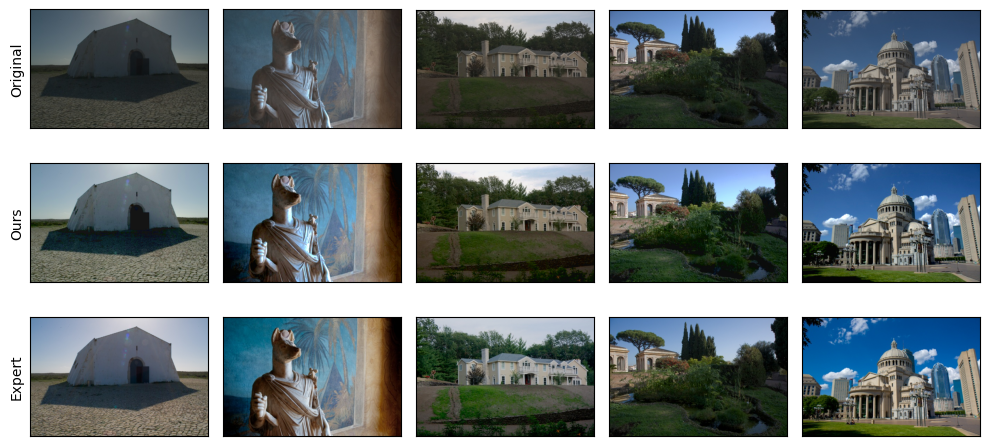

In [8]:
from matplotlib import pyplot as plt
from PIL import Image
NIMAGES = len(images)
fig, ax = plt.subplots(3, NIMAGES, figsize=(10, 5))
for index in range(NIMAGES):
    target = Image.open(targets[index])
    enhanced, original = enhance_image(agent, photo_editor, images[index])
    ax[0][index].imshow(original)
    ax[1][index].imshow(enhanced)
    ax[2][index].imshow(target)
    ax[0][index].set_xticks([])
    ax[0][index].set_yticks([])
    ax[1][index].set_xticks([])
    ax[1][index].set_yticks([])
    ax[2][index].set_xticks([])
    ax[2][index].set_yticks([])
ax[0, 0].set_ylabel("Original", fontsize=10)
ax[1, 0].set_ylabel("Ours", fontsize=10)
ax[2, 0].set_ylabel("Expert", fontsize=10)
plt.tight_layout()
plt.show()

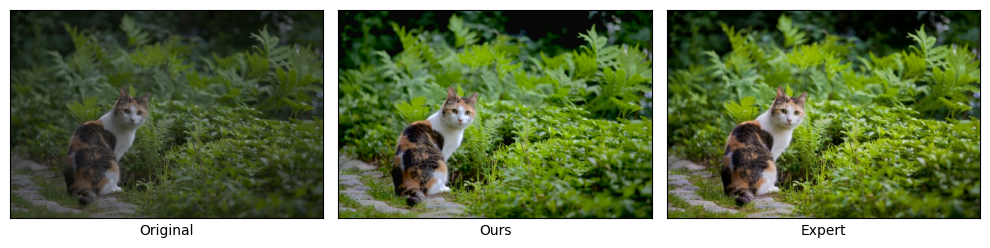

In [9]:
enhanced, original = enhance_image(agent, photo_editor, param_example_img)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 3 columns
target = Image.open(param_example_img_target)
# Display images in the subplots
ax[0].imshow(original)
ax[1].imshow(enhanced)
ax[2].imshow(target)

# Remove ticks from all axes
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
ax[0].set_xlabel("Original", fontsize=10)
ax[1].set_xlabel("Ours", fontsize=10)
ax[2].set_xlabel("Expert", fontsize=10)
plt.tight_layout()
plt.show()


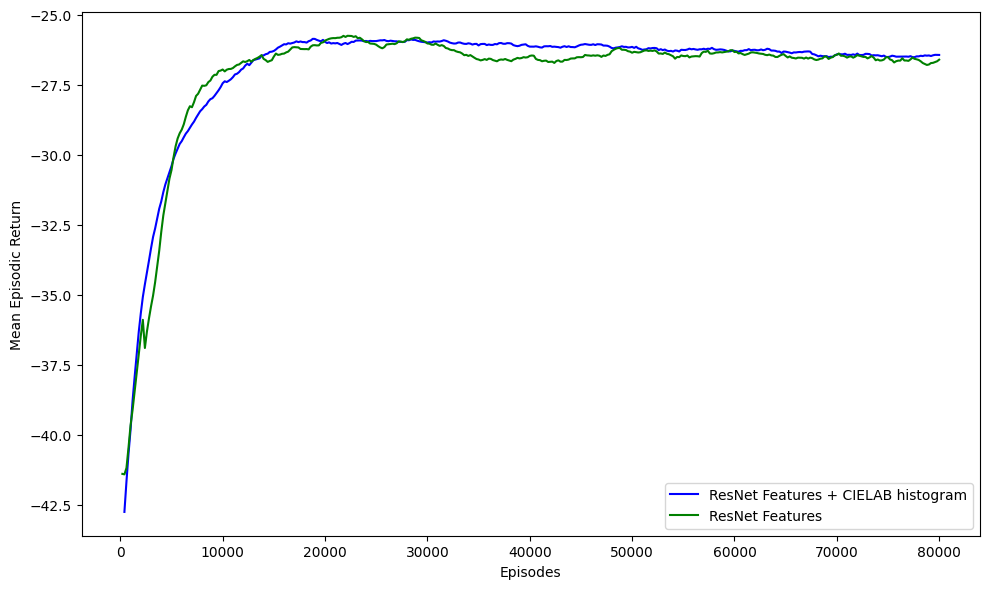

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
df1 = pd.read_csv('Benchmark/ResHist_test_reward.csv')
df2 = pd.read_csv('Benchmark/ResNet_test_reward.csv')

# Apply Exponential Moving Average (EMA) smoothing
smoothing_factor = 0.9
df1['Smoothed Value'] = df1['Value'].ewm(alpha=(1-smoothing_factor)).mean()
df2['Smoothed Value'] = df2['Value'].ewm(alpha=(1-smoothing_factor)).mean()

# Plot the results
plt.figure(figsize=(10, 6))

# Plot both smoothed datasets
plt.plot(df1['Step'], df1['Smoothed Value'], label='ResNet Features + CIELAB histogram', color='blue')
plt.plot(df2['Step'], df2['Smoothed Value'], label='ResNet Features', color='green')

# Labeling the graph
plt.xlabel('Episodes', fontsize=10)
plt.ylabel('Mean Episodic Return', fontsize=10)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [11]:
for k,v in model_paths.items():
    agent,env_config = load_preprocessor_agent(v, DEVICE)
    a,b=compute_500px(agent,env_config)
    print(f'{k} PSNR: {a} SSIM: {b}')

Preloading images and features...


100%|██████████| 500/500 [00:02<00:00, 231.31it/s]


Images and features preloaded and stored in GPU memory.


 38%|███▊      | 191/500 [01:48<02:55,  1.76it/s]


KeyboardInterrupt: 

In [ ]:
'dataset/FiveK/train/input/a0626-20070618_190911__MG_8400.jpg'